In [65]:
%matplotlib inline

In [66]:
import sys
sys.path.append("..")
from altrade.stockdata import *
import pandas.io.data as web

class TickData:
    """ Store a single unit of data """
    def __init__(self, symbol, timestamp, last_price=0, total_volume=0):
        self.symbol = symbol
        self.timestamp = timestamp
        self.open_price = 0
        self.last_price = last_price
        self.total_volume = total_volume


class MarketData:
    def __init__(self):
        self.__recent_ticks__ = dict()

    def add_last_price(self, time, symbol, price, volume):
        tick_data = TickData(symbol, time, price, volume)
        self.__recent_ticks__[symbol] = tick_data

    def add_open_price(self, time, symbol, price):
        tick_data = self.get_existing_tick_data(symbol, time)
        tick_data.open_price = price

    def get_existing_tick_data(self, symbol, time):
        if not symbol in self.__recent_ticks__:
            tick_data = TickData(symbol, time)
            self.__recent_ticks__[symbol] = tick_data
        return self.__recent_ticks__[symbol]

    def get_last_price(self, symbol):
        return self.__recent_ticks__[symbol].last_price

    def get_open_price(self, symbol):
        return self.__recent_ticks__[symbol].open_price

    def get_timestamp(self, symbol):
        return self.__recent_ticks__[symbol].timestamp


class Order:
    def __init__(self, timestamp, symbol, qty, is_buy,
        is_market_order, price=0):
        self.timestamp = timestamp
        self.symbol = symbol
        self.qty = qty
        self.price = price
        self.is_buy = is_buy
        self.is_market_order = is_market_order
        self.is_filled = False
        self.filled_price = 0
        self.filled_time = None
        self.filled_qty = 0


class Position:
    def __init__(self):
        self.symbol = None
        self.buys, self.sells, self.net = 0, 0, 0
        self.realized_pnl = 0  # profit and loss
        self.unrealized_pnl = 0  
        self.position_value = 0  

    def event_fill(self, timestamp, is_buy, qty, price):
        if is_buy:
            self.buys += qty
        else:
            self.sells += qty
        self.net = self.buys - self.sells
        changed_value = qty * price * (-1 if is_buy else 1)
        self.position_value += changed_value
        if self.net == 0:
            self.realized_pnl = self.position_value

    def update_unrealized_pnl(self, price):
        if self.net == 0:
            self.unrealized_pnl = 0
        else:
            self.unrealized_pnl = price * self.net + \
                                    self.position_value
        return self.unrealized_pnl


class Strategy:
    """ Base strategy for implementation """
    def __init__(self):
        self.event_sendorder = None

    def event_tick(self, market_data):
        pass

    def event_order(self, order):
        pass

    def event_position(self, positions):
        pass

    def send_market_order(self, symbol, qty, is_buy, timestamp):
        if not self.event_sendorder is None:
            order = Order(timestamp, symbol, qty, is_buy, True)
            self.event_sendorder(order)


In [109]:
import pandas as pd
class MeanRevertingStrategy(Strategy):
    """ Implementation of a mean-reverting strategy
    based on the Strategy class """
    def __init__(self, symbol, lookback_intervals=20,
                buy_threshold=1.5, sell_threshold=-1.5):
        Strategy.__init__(self)
        self.symbol = symbol
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.prices = pd.DataFrame()
        self.is_long, self.is_short = False, False

    def event_position(self, positions):
        if self.symbol in positions:
            position = positions[self.symbol]
            self.is_long = True if position.net > 0 else False
            self.is_short = True if position.net < 0 else False

    def event_tick(self, market_data):
        self.store_prices(market_data)
        if len(self.prices) < self.lookback_intervals:
            return
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)
        print "            =====@date %s Z score ========> %s"%(timestamp, signal_value)
        if signal_value > self.buy_threshold:
            self.on_buy_signal(timestamp)
        elif signal_value < self.sell_threshold:
            self.on_sell_signal(timestamp)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        self.prices.loc[timestamp, "close"] = \
                market_data.get_last_price(self.symbol)
        self.prices.loc[timestamp, "open"] = \
                market_data.get_open_price(self.symbol)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices["close"].pct_change().dropna()
        z_score = ((returns-returns.mean())/returns.std())[-1]
        return z_score

    def on_buy_signal(self, timestamp):
        if not self.is_long:
            self.send_market_order(self.symbol, 100,
                                   True, timestamp)
    def on_sell_signal(self, timestamp):
        if not self.is_short:
            self.send_market_order(self.symbol, 100,
                                    False, timestamp)


In [110]:
class MarketDataSource:
    def __init__(self, ticker, dirname):
        self.event_tick = None
        self.ticker = ticker
        self.source = 'tdx'
        self.start, self.end = None, None
        self.md = MarketData()
        self.data = None
        self.dirname = dirname

    def get_datum(self):
        if self.source == "yahoo":
            self.data = web.DataReader(self.ticker, self.source, self.start, self.end)
        else:
            # dirname =  "d://new_tdx"
            _path = "//vipdoc//sz//lday//"
            # _path =  "..//tests//datum//"
            fullname =self.dirname+ _path + self.ticker + ".day"
            pddata = daysDataOfStock(fullname)
            self.data = pddata.DF[self.start:self.end]
            # self.data = pddata.DF[self.start:self.end]
    def start_market_simulation(self):
        self.get_datum()
        for time, row in self.data.iterrows():
            # print  "TIME is %s, and row ==> %s" %(time,row)
            if self.source == "yahoo":
                self.md.add_last_price(time, self.ticker, row["Adj Close"], row["Volume"])
                # print "Adj Close=== %s"%row["Adj Close"]
                self.md.add_open_price(time, self.ticker, row["Adj Close"])
            else:
                self.md.add_last_price(time, self.ticker, row["close"], row["vol"])
                self.md.add_open_price(time, self.ticker, row["open"])
            if not self.event_tick is None:
                self.event_tick(self.md)
                

import datetime as dt
import pandas as pd
class Backtester:
    def __init__(self, symbol, start_date, end_date,
        data_source="yahoo"):
        self.target_symbol = symbol
        # when use tdx as data_source
        self.data_source = data_source
        self.start_dt = start_date
        self.end_dt = end_date
        self.strategy = None
        self.unfilled_orders = []
        self.positions = dict()
        self.current_prices = None
        self.rpnl, self.upnl = pd.DataFrame(), pd.DataFrame()

    def get_timestamp(self):
        return self.current_prices.get_timestamp(self.target_symbol)

    def get_trade_date(self):
        timestamp = self.get_timestamp()
        return timestamp.strftime("%Y-%m-%d")

    def update_filled_position(self, symbol, qty, is_buy,
                                price, timestamp):
        position = self.get_position(symbol)
        position.event_fill(timestamp, is_buy, qty, price)
        self.strategy.event_position(self.positions)
        self.rpnl.loc[timestamp, "rpnl"] = position.realized_pnl
        print self.get_trade_date(), \
                "Filled:", "BUY" if is_buy else "SELL", \
                qty, symbol, "at", price

    def get_position(self, symbol):
        if symbol not in self.positions:
            position = Position()
            position.symbol = symbol
            self.positions[symbol] = position
        return self.positions[symbol]

    def evthandler_order(self, order):
        self.unfilled_orders.append(order)
        print self.get_trade_date(), \
            "Received order:", \
            "BUY" if order.is_buy else "SELL", order.qty, \
            order.symbol

    def match_order_book(self, prices):
        if len(self.unfilled_orders) > 0:
            self.unfilled_orders = \
                [order for order in self.unfilled_orders
                    if self.is_order_unmatched(order, prices)]

    def is_order_unmatched(self, order, prices):
        symbol = order.symbol
        timestamp = prices.get_timestamp(symbol)
        if order.is_market_order and timestamp > order.timestamp:
            # Order is matched and filled.
            order.is_filled = True
            open_price = prices.get_open_price(symbol)
            order.filled_timestamp = timestamp
            order.filled_price = open_price
            self.update_filled_position(symbol,
                    order.qty,
                    order.is_buy,
                    open_price,
                    timestamp)
            self.strategy.event_order(order)
            return False
        return True

    def print_position_status(self, symbol, prices):
        if symbol in self.positions:
            position = self.positions[symbol]
            close_price = prices.get_last_price(symbol)
            position.update_unrealized_pnl(close_price)
            self.upnl.loc[self.get_timestamp(), "upnl"] = \
                        position.unrealized_pnl
            print self.get_trade_date(), \
                    "Net:", position.net, \
                    "Value:", position.position_value, \
                    "UPnL:", position.unrealized_pnl, \
                    "RPnL:", position.realized_pnl

    def evthandler_tick(self, prices):
        self.current_prices = prices
        self.strategy.event_tick(prices)
        self.match_order_book(prices)
        self.print_position_status(self.target_symbol, prices)

    def start_backtest(self,dir):
        self.strategy = MeanRevertingStrategy(self.target_symbol)
        self.strategy.event_sendorder = self.evthandler_order
        mds = MarketDataSource(self.target_symbol,dir)
        mds.get_datum()
        mds.event_tick = self.evthandler_tick
        mds.ticker = self.target_symbol
        mds.source = self.data_source
        mds.start, mds.end = self.start_dt, self.end_dt
        print "Backtesting started..."
        mds.start_market_simulation()
        print "Completed."


In [111]:
#mds = MarketDataSource("sz000050", "D:\\tools\\new_tdx\\")

In [112]:
# mds.get_datum()

In [113]:
# mds.start_market_simulation

In [120]:
backtester = Backtester("sz300327", dt.datetime(2015, 1, 1), dt.datetime(2016, 4, 10),"tdx")

In [121]:
backtester.start_backtest("D:\\tools\\new_tdx\\")

Backtesting started...
            =====@date 2015-01-30 00:00:00 Z score ========> -0.519965101505
            =====@date 2015-02-02 00:00:00 Z score ========> 0.206185355379
            =====@date 2015-02-03 00:00:00 Z score ========> 0.655663520929
            =====@date 2015-02-04 00:00:00 Z score ========> -0.314155073106
            =====@date 2015-02-05 00:00:00 Z score ========> -0.178172527979
            =====@date 2015-02-06 00:00:00 Z score ========> -2.27048153764
2015-02-06 Received order: SELL 100 sz300327
            =====@date 2015-02-09 00:00:00 Z score ========> -1.12174060551
2015-02-09 Filled: SELL 100 sz300327 at 14.98
2015-02-09 Net: -100 Value: 1498.0 UPnL: 38.0 RPnL: 0
            =====@date 2015-02-10 00:00:00 Z score ========> 0.888135354384
2015-02-10 Net: -100 Value: 1498.0 UPnL: -10.0 RPnL: 0
            =====@date 2015-02-11 00:00:00 Z score ========> 0.169433520306
2015-02-11 Net: -100 Value: 1498.0 UPnL: -29.0 RPnL: 0
            =====@date 2015-02-12 0

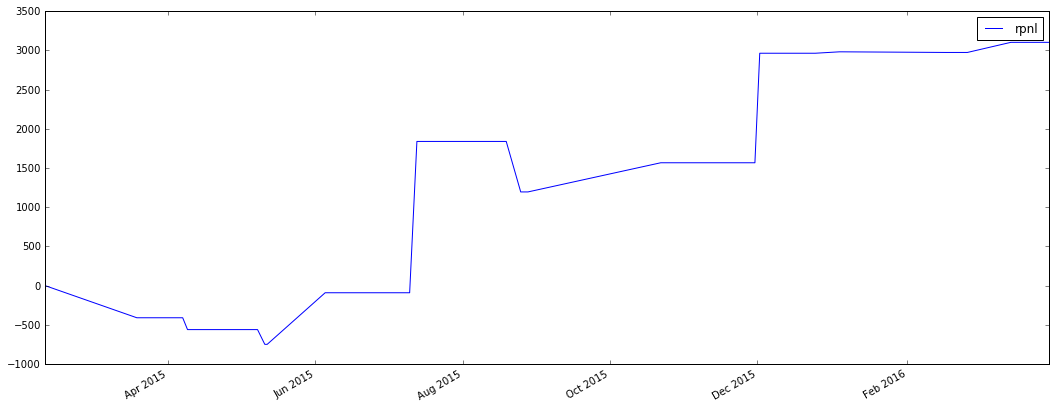

In [122]:
backtester.rpnl.plot(figsize=(18,7))

In [55]:
mds.data.tail()

,open,high,low,close,vol
date_idx,,,,,
2016-04-05,59.18,60.23,58.53,58.97,1432.9541
2016-04-06,58.54,58.95,57.90,58.35,966.9631
2016-04-07,58.48,58.66,56.69,57.05,888.0572
2016-04-08,56.60,57.95,56.57,57.70,716.6621
2016-04-11,57.70,58.83,57.41,57.83,846.7590


In [56]:
returns = mds.data["close"].pct_change().dropna()

In [57]:
returns.describe()

count    1145.000000
mean        0.001296
std         0.034153
min        -0.100049
25%        -0.018935
50%         0.000000
75%         0.018629
max         0.100219
Name: close, dtype: float64

In [58]:
returns[returns>0.099]

date_idx
2011-07-01    0.100196
2011-07-04    0.100000
2011-11-01    0.100219
2011-11-14    0.100000
2013-05-06    0.100000
2013-05-09    0.100101
2013-05-14    0.100000
2013-07-01    0.099967
2013-09-06    0.100000
2013-09-11    0.099947
2014-02-10    0.100000
2014-02-26    0.100082
2014-05-26    0.100095
2015-02-13    0.100053
2015-02-16    0.100072
2015-02-17    0.099913
2015-03-05    0.100019
2015-04-01    0.100000
2015-04-23    0.100087
2015-05-21    0.100015
2015-06-04    0.100000
2015-06-30    0.099980
2015-07-09    0.100045
2015-07-10    0.100102
2015-07-13    0.100055
2015-07-29    0.100000
2015-08-06    0.100084
2015-08-26    0.099901
2015-08-27    0.100068
2015-09-16    0.100106
2015-10-19    0.100000
2015-10-26    0.100016
Name: close, dtype: float64

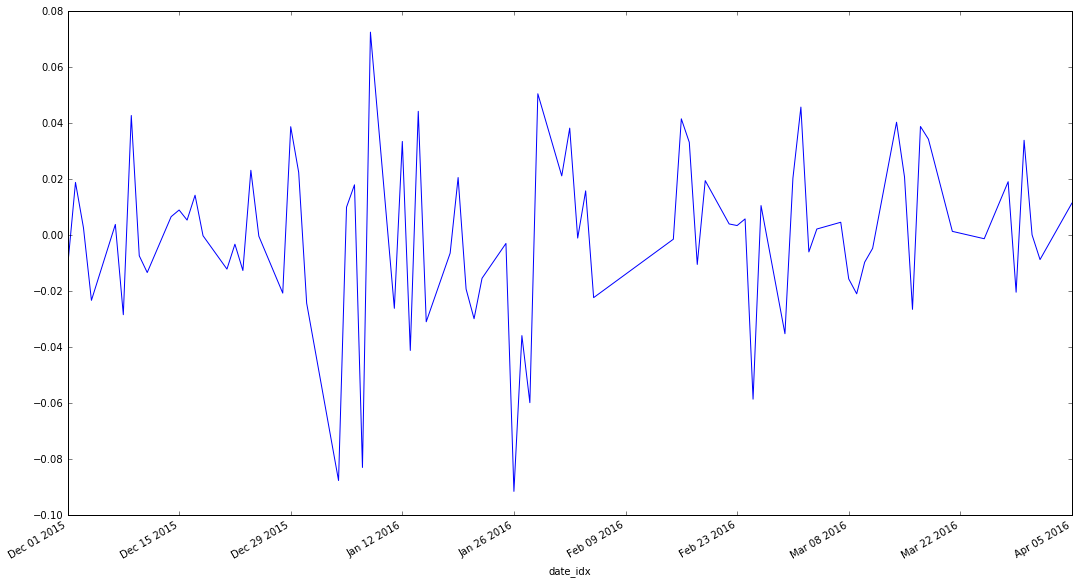

In [59]:
returns["2015-12-01":"2016-04-05"].plot(figsize=(18,10))

In [60]:
 z_score = ((returns-returns.mean())/returns.std())

In [61]:
zscore1516 = z_score["2015-01-01":"2016-04-05"]

In [62]:
zscore1516.describe()

count    292.000000
mean       0.033131
std        1.270360
min       -2.966499
25%       -0.655303
50%        0.003358
75%        0.664295
max        2.893189
Name: close, dtype: float64

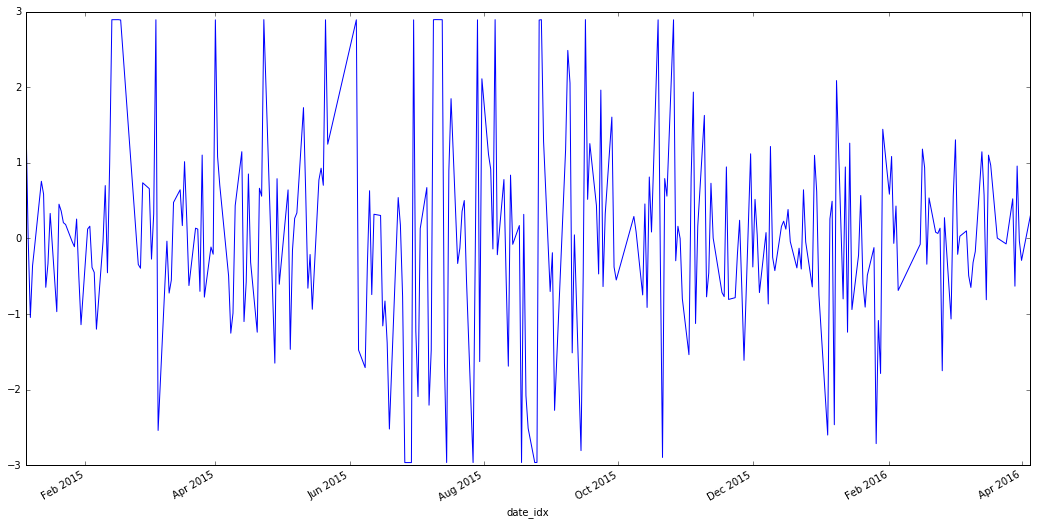

In [63]:
zscore1516.plot(figsize=(18,9))